|     |**sklearn LogisticRegression**|**fromScratch LogisticRegression**|
|:-----|:----------------------------|:----------------------------------|
|Accuracy(Kbest Feature selection)| 86.9% | 65.2%|
|Accuracy(RFE Feature selection)| 83.6%|64.1%|

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectKBest , f_classif, RFE 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix 

In [2]:
def get_boundaries(df,column_name):
    
    # finding IQR 
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # getting upper&lower bound
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    
    return upper,lower

In [3]:
def sigmoid(z):
    return 1 / (1+ np.exp(-z))

In [4]:
def gradient_descent(X,Y,n_iter,alpha):
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)  # Ensure Y has shape (m, 1)
    num_of_features = X.shape[1]
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.random.rand(num_of_features + 1, 1)

    for i in range(n_iter):
        gradients = (2/X.shape[0]) * X_b.T.dot(X_b.dot(theta) - Y)
        theta = theta -  alpha * gradients
        
    return theta

In [5]:
def predict(X,theta):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    z = X_b.dot(theta)
    h_x = sigmoid(z)
    
    # return binary classiffication 0,1
    prediction = (h_x>=0.5).astype(int)
    
    return prediction

## loading the data

In [6]:
df = pd.read_csv("F:\Matrials\CORELIA Internship\ML tasks\heart.csv")

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [9]:
# checking for dublicates
df.duplicated().sum()

0

In [10]:
# are there null values?
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [11]:
# data shape
df.shape

(918, 12)

In [12]:
# unique values in 'ChestPainType' column
df['ChestPainType'].unique()

array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object)

In [13]:
# unique values in 'RestingECG' column
df['RestingECG'].unique()

array(['Normal', 'ST', 'LVH'], dtype=object)

In [14]:
# unique values in 'ST_Slope' column
df['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [15]:
df['ExerciseAngina'].unique()

array(['N', 'Y'], dtype=object)

## performing some EDA

In [16]:
# number of males that have HeartDisease
male_counts=df[(df['Sex']=='M')& (df['HeartDisease']==1)].shape[0]

In [17]:
# number of females that have HeartDisease
female_counts= df[(df['Sex']=='F') & (df['HeartDisease']==1)].shape[0]

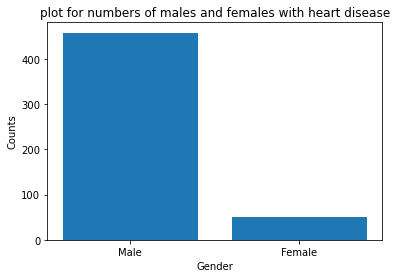

In [18]:
plt.bar(['Male','Female'],[male_counts,female_counts])
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('plot for numbers of males and females with heart disease')
plt.show()

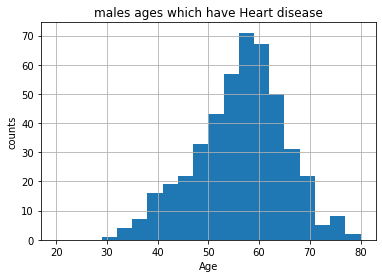

In [19]:
# most male ages with heart disease
df[(df['Sex']=='M')& (df['HeartDisease']==1)].hist('Age',bins=20,range=[20,80])
plt.xlabel('Age')
plt.ylabel('counts')
plt.title('males ages which have Heart disease')
plt.show()

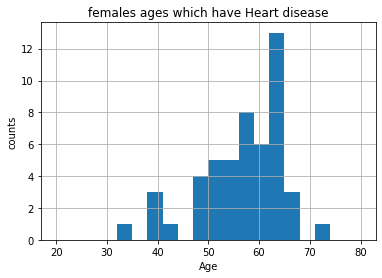

In [20]:
# most female ages with heart disease
df[(df['Sex']=='F') & (df['HeartDisease']==1)].hist('Age',bins=20,range=[20,80])
plt.xlabel('Age')
plt.ylabel('counts')
plt.title('females ages which have Heart disease')
plt.show()

## handeling outliers (capping & log transformation)

In [21]:
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


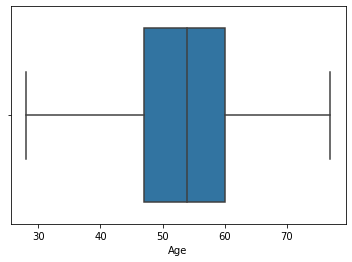

In [22]:
# checking for outliers in Age column
sns.boxplot(x=df['Age'])
plt.show()

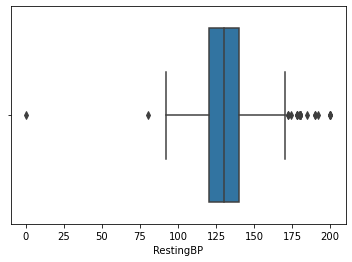

In [23]:
# checking for outliers in restingBP column
sns.boxplot(x=df['RestingBP'])
plt.show()

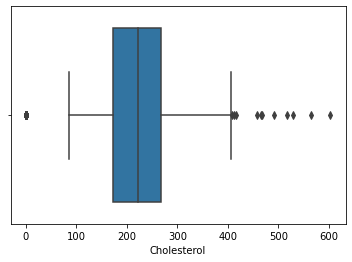

In [24]:
# checking for outliers in Cholesterol column
sns.boxplot(x=df['Cholesterol'])
plt.show()

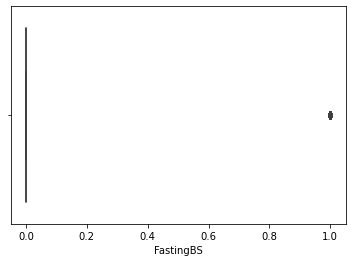

In [25]:
# checking for outliers in FastingBS column
sns.boxplot(x=df['FastingBS'])
plt.show()

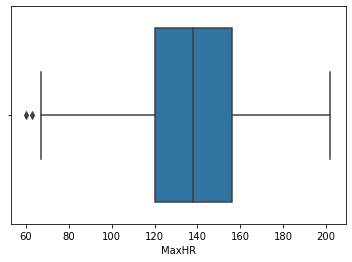

In [26]:
# checking for outliers in MaxHR column
sns.boxplot(x=df['MaxHR'])
plt.show()

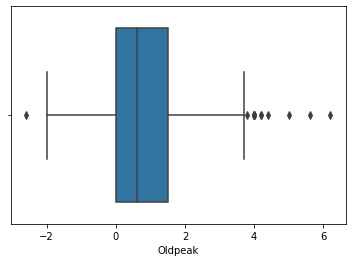

In [27]:
# checking for outliers in Oldpeak column
sns.boxplot(x=df['Oldpeak'])
plt.show()

In [28]:
#handling ouliers using log transformation 
## df['Oldpeak'] = np.log1p(df['Oldpeak'])

In [29]:
##df['Oldpeak'].isna().sum()

In [30]:
'''
df['MaxHR'] = np.log1p(df['MaxHR'])
df['FastingBS'] = np.log1p(df['FastingBS'])
df['Cholesterol'] = np.log1p(df['Cholesterol'])
df['RestingBP'] = np.log1p(df['RestingBP'])
'''

"\ndf['MaxHR'] = np.log1p(df['MaxHR'])\ndf['FastingBS'] = np.log1p(df['FastingBS'])\ndf['Cholesterol'] = np.log1p(df['Cholesterol'])\ndf['RestingBP'] = np.log1p(df['RestingBP'])\n"

In [31]:
# getting upper & lower bounds for each column that has outliers
upper_oldpeak , lower_oldpeak = get_boundaries(df,'Oldpeak')
upper_maxHR , lower_maxHR = get_boundaries(df,'MaxHR')
upper_fastingBS , lower_fastingBS = get_boundaries(df,'FastingBS')
upper_cholesterol , lower_cholesterol = get_boundaries(df,'Cholesterol')
upper_restingBP , lower_restingBP = get_boundaries(df,'RestingBP')

In [32]:
print('oldpeak upper&lower bounds: ', upper_oldpeak,',',lower_oldpeak)
print('maxHR upper&lower bounds: ', upper_maxHR,',',lower_maxHR)
print('fastingBS upper&lower bounds: ', upper_fastingBS,',',lower_fastingBS)
print('Cholesterol upper&lower bounds: ', upper_cholesterol,',' , lower_cholesterol)
print('RestingBP upper&lower bounds: ', upper_restingBP ,',', lower_restingBP)

oldpeak upper&lower bounds:  3.75 , -2.25
maxHR upper&lower bounds:  210.0 , 66.0
fastingBS upper&lower bounds:  0.0 , 0.0
Cholesterol upper&lower bounds:  407.625 , 32.625
RestingBP upper&lower bounds:  170.0 , 90.0


In [33]:
# capping outliers with lower&upper bounds
df['Oldpeak'] = np.where(df['Oldpeak']> upper_oldpeak, upper_oldpeak,
                        np.where(df['Oldpeak']<lower_oldpeak,lower_oldpeak, df['Oldpeak']))
df['MaxHR'] = np.where(df['MaxHR']>upper_maxHR , upper_maxHR,
                      np.where(df['MaxHR']< lower_maxHR , lower_maxHR , df['MaxHR']))
df['FastingBS'] = np.where(df['FastingBS']>upper_fastingBS , upper_fastingBS,
                          np.where(df['FastingBS']< lower_fastingBS , lower_fastingBS , df['FastingBS']))
df['Cholesterol'] = np.where(df['Cholesterol']>upper_cholesterol, upper_cholesterol,
                            np.where(df['Cholesterol']<lower_cholesterol,lower_cholesterol , df['Cholesterol']))
df['RestingBP'] = np.where(df['RestingBP']> upper_restingBP , upper_restingBP,
                          np.where(df['RestingBP']< lower_restingBP , lower_restingBP , df['RestingBP']))

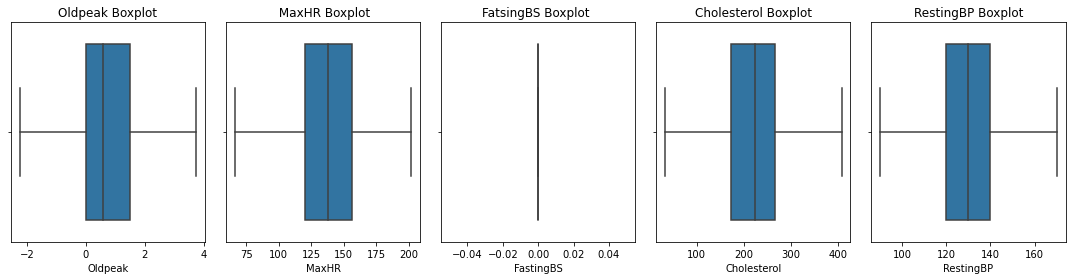

In [34]:
# Create a figure with 5 subplots in a single row
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

# Plot boxplots on each subplot using Seaborn
sns.boxplot(x=df['Oldpeak'], ax=axs[0])
axs[0].set_title('Oldpeak Boxplot')

sns.boxplot(x= df['MaxHR'] , ax=axs[1])
axs[1].set_title(' MaxHR Boxplot')

sns.boxplot(x= df['FastingBS'] , ax=axs[2])
axs[2].set_title('FatsingBS Boxplot ')

sns.boxplot(x=df['Cholesterol'], ax=axs[3])
axs[3].set_title('Cholesterol Boxplot')

sns.boxplot(x=df['RestingBP'], ax=axs[4])
axs[4].set_title('RestingBP Boxplot')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## scaling numerical Features

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    float64
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    float64
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 86.2+ KB


In [36]:
numerical_features = ['Age','RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [37]:
scaler = StandardScaler()

In [38]:
data_to_scale = df[numerical_features]

In [39]:
data_to_scale.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,40,140.0,289.0,0.0,172.0,0.0
1,49,160.0,180.0,0.0,156.0,1.0
2,37,130.0,283.0,0.0,98.0,0.0
3,48,138.0,214.0,0.0,108.0,1.5
4,54,150.0,195.0,0.0,122.0,0.0


In [40]:
scaled_data = scaler.fit_transform(data_to_scale)

In [41]:
scaled_data.shape

(918, 6)

In [42]:
df[numerical_features] = scaled_data

In [43]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,M,ATA,0.463654,0.886771,0.0,Normal,1.384080,N,-0.851276,Up,0
1,-0.478484,F,NAP,1.641229,-0.250184,0.0,Normal,0.754610,N,0.118532,Flat,1
2,-1.751359,M,ATA,-0.125133,0.824187,0.0,ST,-1.527219,N,-0.851276,Up,0
3,-0.584556,F,ASY,0.345897,0.104463,0.0,Normal,-1.133801,Y,0.603436,Flat,1
4,0.051881,M,NAP,1.052442,-0.093722,0.0,Normal,-0.583014,N,-0.851276,Up,0


## Encoding categorical data

In [44]:
df = df.join(pd.get_dummies(df['Sex'], drop_first=True))


In [45]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,M
0,-1.433140,M,ATA,0.463654,0.886771,0.0,Normal,1.384080,N,-0.851276,Up,0,1
1,-0.478484,F,NAP,1.641229,-0.250184,0.0,Normal,0.754610,N,0.118532,Flat,1,0
2,-1.751359,M,ATA,-0.125133,0.824187,0.0,ST,-1.527219,N,-0.851276,Up,0,1
3,-0.584556,F,ASY,0.345897,0.104463,0.0,Normal,-1.133801,Y,0.603436,Flat,1,0
4,0.051881,M,NAP,1.052442,-0.093722,0.0,Normal,-0.583014,N,-0.851276,Up,0,1


In [46]:
df= df.join(pd.get_dummies(df['ChestPainType'], drop_first=True))

In [47]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,M,ATA,NAP,TA
0,-1.433140,M,ATA,0.463654,0.886771,0.0,Normal,1.384080,N,-0.851276,Up,0,1,1,0,0
1,-0.478484,F,NAP,1.641229,-0.250184,0.0,Normal,0.754610,N,0.118532,Flat,1,0,0,1,0
2,-1.751359,M,ATA,-0.125133,0.824187,0.0,ST,-1.527219,N,-0.851276,Up,0,1,1,0,0
3,-0.584556,F,ASY,0.345897,0.104463,0.0,Normal,-1.133801,Y,0.603436,Flat,1,0,0,0,0
4,0.051881,M,NAP,1.052442,-0.093722,0.0,Normal,-0.583014,N,-0.851276,Up,0,1,0,1,0


In [48]:
df = df.join(pd.get_dummies(df['RestingECG'],drop_first=True))

In [49]:
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,M,ATA,NAP,TA,Normal,ST
0,-1.433140,M,ATA,0.463654,0.886771,0.0,Normal,1.384080,N,-0.851276,Up,0,1,1,0,0,1,0
1,-0.478484,F,NAP,1.641229,-0.250184,0.0,Normal,0.754610,N,0.118532,Flat,1,0,0,1,0,1,0
2,-1.751359,M,ATA,-0.125133,0.824187,0.0,ST,-1.527219,N,-0.851276,Up,0,1,1,0,0,0,1


In [50]:
df= df.join(pd.get_dummies(df['ExerciseAngina'], drop_first=True))

In [51]:
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,M,ATA,NAP,TA,Normal,ST,Y
0,-1.433140,M,ATA,0.463654,0.886771,0.0,Normal,1.384080,N,-0.851276,Up,0,1,1,0,0,1,0,0
1,-0.478484,F,NAP,1.641229,-0.250184,0.0,Normal,0.754610,N,0.118532,Flat,1,0,0,1,0,1,0,0
2,-1.751359,M,ATA,-0.125133,0.824187,0.0,ST,-1.527219,N,-0.851276,Up,0,1,1,0,0,0,1,0


In [52]:
df = df.join(pd.get_dummies(df['ST_Slope'] , drop_first=True))

In [53]:
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,HeartDisease,M,ATA,NAP,TA,Normal,ST,Y,Flat,Up
0,-1.433140,M,ATA,0.463654,0.886771,0.0,Normal,1.384080,N,-0.851276,...,0,1,1,0,0,1,0,0,0,1
1,-0.478484,F,NAP,1.641229,-0.250184,0.0,Normal,0.754610,N,0.118532,...,1,0,0,1,0,1,0,0,1,0
2,-1.751359,M,ATA,-0.125133,0.824187,0.0,ST,-1.527219,N,-0.851276,...,0,1,1,0,0,0,1,0,0,1


In [54]:
df.drop(['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina', 'ST_Slope'],axis=1, inplace=True)

In [55]:
df.head(3)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,M,ATA,NAP,TA,Normal,ST,Y,Flat,Up
0,-1.433140,0.463654,0.886771,0.0,1.384080,-0.851276,0,1,1,0,0,1,0,0,0,1
1,-0.478484,1.641229,-0.250184,0.0,0.754610,0.118532,1,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.125133,0.824187,0.0,-1.527219,-0.851276,0,1,1,0,0,0,1,0,0,1


## Feature selection 

In [56]:
X = df.drop('HeartDisease' , axis=1)
y = df['HeartDisease']

In [57]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,M,ATA,NAP,TA,Normal,ST,Y,Flat,Up
0,-1.433140,0.463654,0.886771,0.0,1.384080,-0.851276,1,1,0,0,1,0,0,0,1
1,-0.478484,1.641229,-0.250184,0.0,0.754610,0.118532,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.125133,0.824187,0.0,-1.527219,-0.851276,1,1,0,0,0,1,0,0,1
3,-0.584556,0.345897,0.104463,0.0,-1.133801,0.603436,0,0,0,0,1,0,1,1,0
4,0.051881,1.052442,-0.093722,0.0,-0.583014,-0.851276,1,0,1,0,1,0,0,0,1


In [58]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

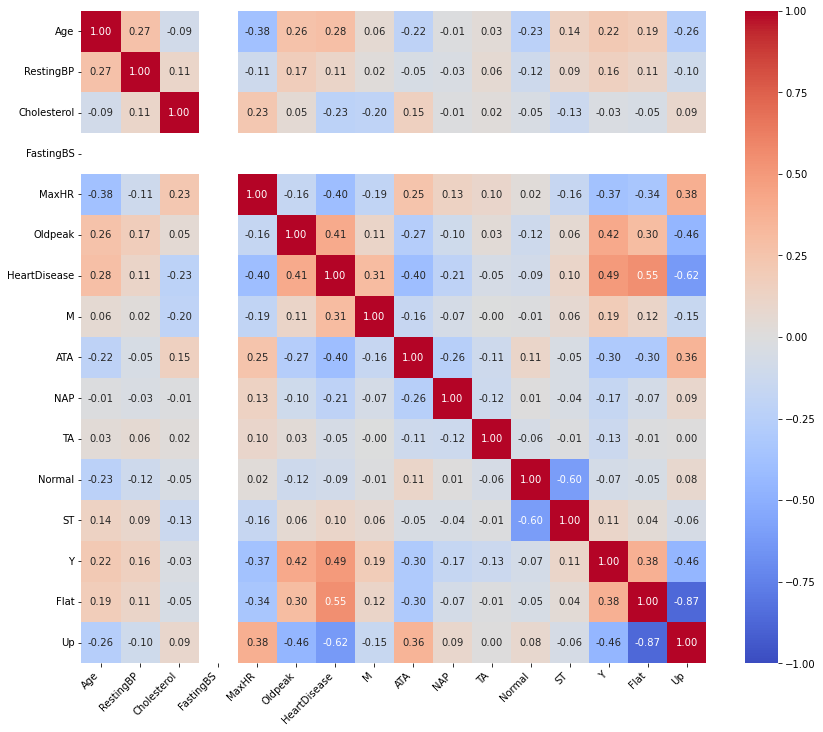

In [59]:
# correlation matrix 
correlation_matrix = df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(14, 12))


sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)

# Rotate the x-axis labels 
plt.xticks(rotation=45, ha="right")

# Rotate the y-axis labels 
plt.yticks(rotation=0)

# Display the plot
plt.show()

In [60]:
# trying selectKBest 
selector = SelectKBest(score_func=f_classif, k=10)
X_k_best = selector.fit_transform(X,y)

C:\Users\01272\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [3] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\01272\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [61]:
kbest_scores = selector.scores_

In [62]:
# indices of the slected features
selector.get_support(indices=True)

array([ 0,  2,  4,  5,  6,  7,  8, 12, 13, 14], dtype=int64)

In [63]:
pd.DataFrame({'features':X.columns, 'scores': kbest_scores}).sort_values(by='scores', ascending=False).head(10)

,features,scores
14,Up,578.505658
13,Flat,405.911473
12,Y,296.144771
5,Oldpeak,185.322761
7,ATA,176.482905
4,MaxHR,175.016313
6,M,94.253184
0,Age,79.160779
2,Cholesterol,48.984499
8,NAP,43.517481


## classification (KBest features)

In [64]:
X_b_train, X_b_test , y_train , y_test = train_test_split(X_k_best,y , test_size=0.2, shuffle=True)

In [65]:
theta_kbest = gradient_descent(X_b_train,y_train,100000,0.1)

In [66]:
y_kbest_pred = predict(X_b_test,theta_kbest)

In [67]:
accuracy_score(y_test,y_kbest_pred)

0.6521739130434783

In [68]:
lr = LogisticRegression(penalty='none')

In [69]:
lr.fit(X_b_train,y_train)

LogisticRegression(penalty='none')

In [70]:
lr_pred = lr.predict(X_b_test)

In [71]:
accuracy_score(y_test,lr_pred)

0.8695652173913043

---------------------
### RFE

In [72]:
model = LogisticRegression()

In [73]:
rfe = RFE(model,n_features_to_select=10)

In [74]:
# train/test split 
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2 , shuffle=True)

In [75]:
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [76]:
# the selected columns 
X.columns[rfe.support_]

Index(['Age', 'Cholesterol', 'Oldpeak', 'M', 'ATA', 'NAP', 'TA', 'Y', 'Flat',
       'Up'],
      dtype='object')

In [77]:
rfe.ranking_

array([1, 4, 1, 6, 2, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1])

In [78]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

## classification(Feature selection with RFE)

In [79]:
theta_rfe = gradient_descent(X_train_rfe,y_train,100000,0.1)

In [80]:
y_rfe_pred = predict(X_test_rfe,theta_rfe)

In [81]:
accuracy_score(y_test,y_rfe_pred)

0.6413043478260869

In [82]:
lr2 = LogisticRegression(penalty='none')

In [83]:
lr2.fit(X_train_rfe,y_train)

LogisticRegression(penalty='none')

In [84]:
lr_rfe_pred = lr2.predict(X_test_rfe)

In [85]:
accuracy_score(y_test,lr_rfe_pred)

0.8369565217391305